In [1]:
# Load Stuff

# Paths
import os

# Data
import numpy as np
import pandas as pd
from PIL import Image

# Visualize
import matplotlib.pyplot as plt

# API
import requests

# Preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input

# String Manipulation
import ast
import re


In [2]:
# Functions

# Function to open Image
def get_image(path):
    im = Image.open(path)
    return im

# Function to Reshape Bands into Smaller Pictures (needs to be updated for 3 bands)
def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    assert h % nrows == 0, f"{h} rows is not evenly divisible by {nrows}"
    assert w % ncols == 0, f"{w} cols is not evenly divisible by {ncols}"
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))

# Function to Reshape  Smaller Pictures into Bands (needs to be updated for 3 bands)
def unblockshaped(arr, h, w):
    """
    Return an array of shape (h, w) where
    h * w = arr.size

    If arr is of shape (n, nrows, ncols), n sublocks of shape (nrows, ncols),
    then the returned array preserves the "physical" layout of the sublocks.
    """
    n, nrows, ncols = arr.shape
    return (arr.reshape(h//nrows, -1, nrows, ncols)
               .swapaxes(1,2)
               .reshape(h, w))

# Function to extract small pictures from satellite image 
def get_array_pictures(image, pixels):
    im_array = np.array(image)
    band_dictionary = {}
    for band in range(im_array.shape[2]):
        band_dictionary["band{0}".format(band)] = blockshaped(im_array[:,:,band], pixels, pixels)

    concate_list = [band_dictionary[key] for key in band_dictionary]

    X = np.stack(concate_list, axis = im_array.shape[2])

    return X

# Function to reubuild image from small images (based on original size)
def get_picture_arrays(array, x_shape,y_shape):
    band_dictionary = {}
    for band in range(array.shape[3]):
        band_dictionary["band{0}".format(band)] = unblockshaped(array[:,:,:,band],x_shape,y_shape)

    concate_list = [band_dictionary[key] for key in band_dictionary]

    X_rebuilt_array = np.stack(concate_list, axis = 2)
    X_rebuilt = Image.fromarray(X_rebuilt_array)

    return X_rebuilt


# Function to Convert Output Into Categories
def pred_to_array(y_pred):
    y_pred_cat = np.argmax(y_pred, axis = 1)
    y_pred_cat_reduced = pd.Series(y_pred_cat).map(lambda x: 0 if x == 1 else (1 if x == 0 or x == 2 or x == 5 or x == 6 else (2 if x == 3 else (3 if x == 4 else (4 if x == 7 else 5))))).to_numpy()
    return y_pred_cat_reduced

# Function to Create Dataframe with Distributions 
def categories_df(y_pred_cat):

    classes = {'Forest':0, 'Green':1, 'Highway':2, 'Industrial': 3, 'Residential': 4, 
              'Water': 5}
    classes_swap = dict([(value, key) for key, value in classes.items()])

    # Create Pandas Series
    classes_series = pd.Series(classes_swap, index =[0, 1, 2, 3, 4, 5])
    count_series = pd.Series(y_pred_cat).value_counts().map(lambda x: round(x*0.4096,2))
    percentage_series = pd.Series(y_pred_cat).value_counts(normalize = True).map(lambda x: round(x*100,2))


    #Creating a dictionary by passing Series objects as values
    frame = {'Category': classes_series,
          'Area in Km2': count_series,
          'Percentage': percentage_series }
    #Creating DataFrame by passing Dictionary
    df = pd.DataFrame(frame)
    df = df.set_index('Category').sort_values(by = 'Percentage', ascending = False)      

    #return the dataframe
    return df

# Function to Convert Results into an Image
def categories_to_image(y_pred_cat, original_image):

    rgb_map = {
      0: (55,86,35), # 'Forest'
      1: (69, 204 , 108), # 'Green'
      2: (105,110,106), # 'Highway'
      3 : (255,183,94), # 'Industrial'
      4 : (255,232,154), # 'Residential'
      5 : (0,43,191) # 'Water'
    }

    R,G,B = np.vectorize(rgb_map.get)(y_pred_cat)
    R_arr = np.tile(R[:, np.newaxis, np.newaxis], (1, 64,64))
    G_arr = np.tile(G[:, np.newaxis, np.newaxis], (1, 64,64))
    B_arr = np.tile(B[:, np.newaxis, np.newaxis], (1, 64,64))

    R_rebuilt = unblockshaped(R_arr,im.size[1],im.size[0])
    G_rebuilt = unblockshaped(G_arr,im.size[1],im.size[0])
    B_rebuilt = unblockshaped(B_arr,im.size[1],im.size[0])

    RGB_image = np.stack([R_rebuilt, G_rebuilt, B_rebuilt], axis = 2)

    return RGB_image

# Function to Save as Image (not geo-located)
def save_image(RGB_image, path_oputput):
    image_export = Image.fromarray(RGB_image.astype(np.uint8))
    image_export.save(path_oputput)
    return None

# Function to Save Output and Geo-Raster
def save_tif(path_satellite,path_oputput):
    # 'Load image as Dataset'
    geodataset = rasterio.open(path_satellite) 

    # Reshape Bands for RGB
    raster = reshape_as_raster(RGB_image)

    # Save output
    with rasterio.open(
      path_oputput,
      'w',
      driver='GTiff',
      height=geodataset.height,
      width=geodataset.width,
      count=3,
      dtype='uint8',
      crs=geodataset.crs,
      transform=geodataset.transform,
    ) as dst:
          dst.write(raster)

    return None

# Define Pad Preprocessed
def pad_preprocessed(X_preprocessed, pictures_per_batch, pixels):
    missing_pictures = (pictures_per_batch-X_preprocessed.shape[0]%pictures_per_batch)
    pad_array = np.zeros((missing_pictures,pixels,pixels,3)) # Create n missing_pictures of size (pixel, pixel) in RGB
    X_preprocessed_pad = np.append(X_preprocessed,pad_array, axis = 0) # Append empty pictures
    return X_preprocessed_pad

In [3]:
# Set Path
os.chdir('/Users/franciscogarcia/.lewagon/project/data/raw')

In [4]:
# Load Data
im = get_image('Paris.tif')

In [5]:
# Get individual pictures
X = get_array_pictures(im, 64)
X.shape

(2695, 64, 64, 3)

In [6]:
# Preprocess 
X_preprocessed = preprocess_input(X)
X_preprocessed.shape

(2695, 64, 64, 3)

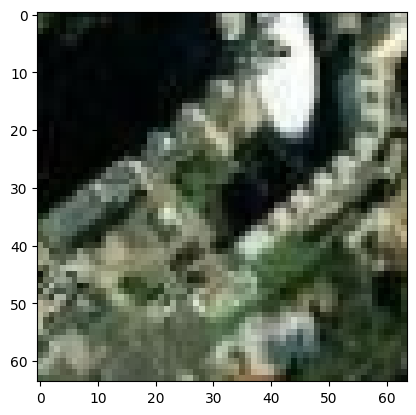

In [28]:
plt.imshow(X[0,:,:,:])

In [7]:
import time

In [38]:
start = time.time()
url = 'https://y-7qespoerca-ew.a.run.app/predict'

data = {'X': X_preprocessed[0:100,:,:,:].tolist()}

response = requests.post(url, json=data)
response.json()
end = time.time()
print(end - start)
print(response.json())

7.713015079498291
{'prediction': '[5, 2, 5, 5, 2, 5, 5, 5, 3, 3, 3, 3, 4, 3, 4, 2, 3, 1, 5, 3, 3, 5, 3, 3, 4, 1, 1, 4, 3, 4, 1, 4, 4, 3, 1, 5, 5, 1, 3, 3, 3, 3, 3, 3, 2, 2, 5, 3, 3, 3, 4, 3, 5, 5, 3, 1, 4, 2, 3, 3, 3, 3, 2, 2, 3, 3, 5, 2, 3, 3, 3, 4, 4, 4, 2, 4, 1, 1, 4, 4, 2, 3, 2, 4, 5, 1, 3, 3, 3, 5, 3, 3, 3, 5, 3, 2, 2, 2, 3, 3]'}


In [35]:
# Full Blown Request
def api_request(url,X_preprocessed,batch_size):
    # Set url
    url = url
    # We pad X_preprocessed for prediction
    X_preprocessed_pad = pad_preprocessed(X_preprocessed, batch_size, 64) # pixels to come form local env
    # We get an empty list for appending results
    response_list_long = []
    # We start a loop for requests
    for i in range(0,X_preprocessed_pad.shape[0],batch_size):
        # We set the data request and batch size
        data = {'X': X_preprocessed_pad[i:i+batch_size,:,:,:].tolist()}
        # We run a request
        response = requests.post(url, json=data)
        # We fix the response to an array
        response_processed = ast.literal_eval(response.json()['prediction'])
        # We append responses to our list
        response_list_long.append(response_processed) 
    # We flatten the list
    response_list_flat = [item for sublist in response_list_long for item in sublist]
    # We Get Padding
    remove_elements = (batch_size - X_preprocessed.shape[0] % batch_size)
    # We extract the last elements from padding
    response_list = response_list_flat[:len(response_list_flat) -
                                       remove_elements]
    # We Return
    y_pred_cat = np.array(response_list)
    return y_pred_cat

In [36]:
start = time.time()
y_pred_cat = api_request('http://localhost:8000/predict',X_preprocessed,500)
end = time.time()
print(end - start)
print(Y_pred_cat.shape)

79.58433294296265
(2695,)


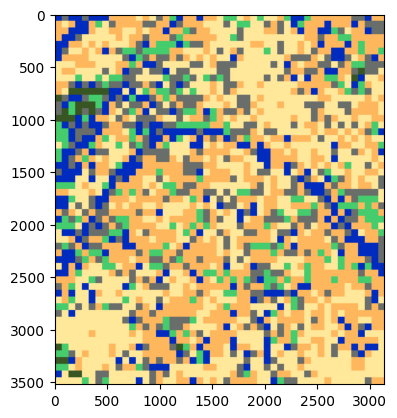

In [39]:
# LEt's just check this works
pred_df = categories_df(Y_pred_cat)
pred_df
# Map Array to RGB Palette
RGB_image = categories_to_image(Y_pred_cat, im)
plt.imshow(RGB_image)

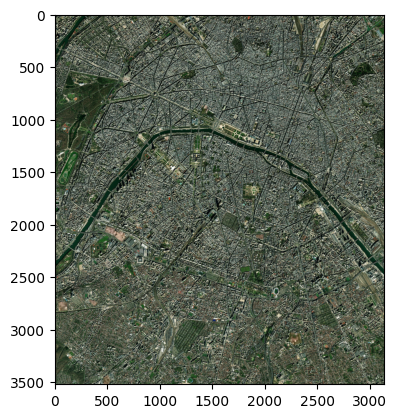

In [40]:
plt.imshow(im)

In [16]:
# Make Request

url = 'https://y-7qespoerca-ew.a.run.app/test'

data = {'X': X_preprocessed[0:10,:,:,:].tolist()}

response = requests.post(url, json=data)
response.json()

{'prediction': '[[0.00000000e+00 0.00000000e+00 4.65160814e-36 4.85936007e-28\n  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00\n  9.99999940e-01 0.00000000e+00]\n [1.36089819e-33 1.24945690e-37 3.27929296e-02 8.60968590e-01\n  1.06237948e-01 0.00000000e+00 5.15305905e-22 4.18762868e-32\n  4.69207492e-07 0.00000000e+00]\n [0.00000000e+00 0.00000000e+00 6.67666069e-20 1.30244926e-10\n  5.05017326e-08 0.00000000e+00 0.00000000e+00 6.89649764e-25\n  9.99999940e-01 0.00000000e+00]\n [9.25168421e-34 2.51109409e-31 7.45392419e-20 5.33629434e-12\n  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00\n  9.99999940e-01 6.24643225e-33]\n [9.60261695e-20 2.50992425e-38 1.51900842e-18 7.09527612e-01\n  2.06930496e-17 1.42291518e-19 9.57757720e-31 1.23598634e-26\n  2.90472299e-01 1.26750546e-25]\n [0.00000000e+00 0.00000000e+00 1.66182465e-36 4.48380477e-32\n  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00\n  9.99999940e-01 0.00000000e+00]\n [0.00000000e+00 0.00000

In [8]:
'''
# Loop Over Request and Get List of Predictions that can be converted to array
url = 'http://127.0.0.1:8000/test'

y_pred_list = []
for i in range(0,X_preprocessed_pad.shape[0],100):
    data = {'X': X_preprocessed_pad[i:i+100,:,:,:].tolist()}
    response = requests.post(url, json=data)
    y_pred = np.array(ast.literal_eval(re.sub(',+',',',response.json()['prediction'].replace(' ',','))))
    y_pred_cat = pred_to_array(y_pred)
    y_pred_list.append(y_pred_cat.tolist())
'''

"\n# Loop Over Request and Get List of Predictions that can be converted to array\nurl = 'http://127.0.0.1:8000/test'\n\ny_pred_list = []\nfor i in range(0,X_preprocessed_pad.shape[0],100):\n    data = {'X': X_preprocessed_pad[i:i+100,:,:,:].tolist()}\n    response = requests.post(url, json=data)\n    y_pred = np.array(ast.literal_eval(re.sub(',+',',',response.json()['prediction'].replace(' ',','))))\n    y_pred_cat = pred_to_array(y_pred)\n    y_pred_list.append(y_pred_cat.tolist())\n"

In [9]:
# Define Function to run API Requests and get Correct array back 

def api_request(url,X_preprocessed,batch_size):
    # Set url
    url = url
    # We pad X_preprocessed for prediction
    X_preprocessed_pad = pad_preprocessed(X_preprocessed, batch_size, 64) # pixels to come form local env
    # We get an empty list for appending results
    response_list_long = []
    # We start a loop for requests
    for i in range(0,X_preprocessed_pad.shape[0],batch_size):
        # We set the data request and batch size
        data = {'X': X_preprocessed_pad[i:i+batch_size,:,:,:].tolist()}
        # We run a request
        response = requests.post(url, json=data)
        # We fix the response to an array
        response_array = np.array(ast.literal_eval(re.sub(',+',',',response.json()['prediction'].replace(' ',','))))
        # We categorize our responses according to model (could polish with more steps)
        response_array_cat = pred_to_array(response_array)
        # We append responses to our list
        response_list_long.append(response_array_cat.tolist()) # Again, could be more efficient
    # We flatten our list
    response_list_flat = [item for sublist in response_list_long for item in sublist]
    # We redefine how many elements we need to remove (could be better)
    remove_elements = (batch_size-X_preprocessed.shape[0]%batch_size)
    # We extract the last elements from padding
    response_list = response_list_flat[: len(response_list_flat) - remove_elements]
    # We return a y_pred_cat for use based on the correct list
    y_pred_cat = np.array(response_list)
    return y_pred_cat

In [10]:
y_pred_cat = api_request('http://127.0.0.1:8000/test',X_preprocessed,100)

In [11]:
pred_df = categories_df(y_pred_cat)
pred_df

,Area in Km2,Percentage
Category,,
Industrial,349.80,31.69
Residential,347.75,31.50
Highway,175.72,15.92
Water,122.88,11.13
Green,97.89,8.87
Forest,9.83,0.89


In [12]:
# Map Array to RGB Palette
RGB_image = categories_to_image(y_pred_cat, im)

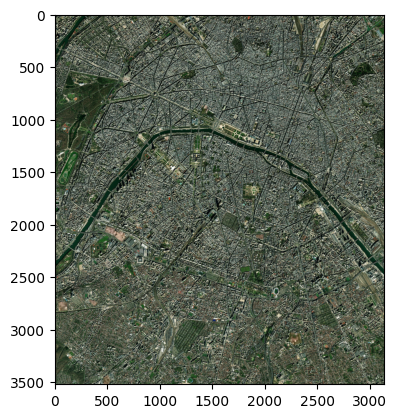

In [13]:
# Show
plt.imshow(im)

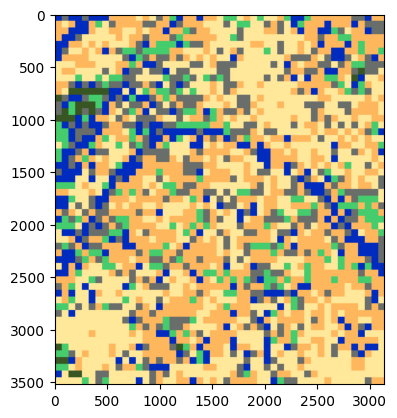

In [14]:
# Show Image
plt.imshow(RGB_image)

In [23]:
len('eu.gcr.io/wagon-bootcamp-328711/city-image')

42